## Что посчиталось

In [383]:
from data_loading import *
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'serif', "serif":"stix",  'size': 26})
rc('text', usetex=True)

In [6]:
from data_loading import *
import glob

In [71]:
# s = [print(x) for x in sorted(glob.glob("../results/dnn/*/*all_runs**"), key = lambda x : x.split("/")[-1])]

# Загрузка модели из истории

In [9]:
import glob
path = "../results/dnn/2019-04-24-10-38"
glob.glob(path + "/*all_runs*")

['../results/dnn/2019-04-24-10-38/dnn_model_1_all_runs_p3_ecoli_100000_10000_24_0.pyob']

In [10]:
from data_loading import *
data = generate_data("../results/ecoli_100000_10000", enviroment_size = 24, shift = 0)[0]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

In [11]:
from keras.models import model_from_json
json_file = open(path+ '/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(path + "/0.weights")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
loaded_model.evaluate(data.test1, data.test_ans)

Using TensorFlow backend.


Loaded model from disk
10000/10000 [==============================] - 2s 202us/step


[1.3559132844924926, 0.33179999999999998]

/home/bvdmitri/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


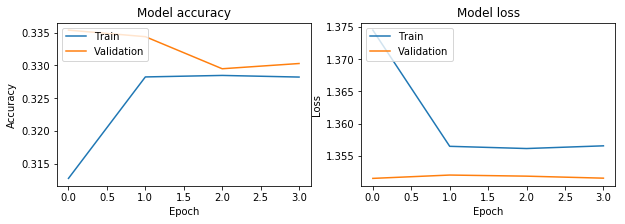

In [24]:
import pickle
%matplotlib inline

with open(path + '/0_history.pyob', "rb") as f:
    history = pickle.load(f)
plot_history(history)

# Проверка генерации данных

In [1]:
from data_loading import *

In [16]:
data_g = generate_data("../results/ecoli_100000_10000", 12)

In [17]:
data = next(data_g)

0 

In [18]:
import numpy as np
import struct
from sys import getsizeof

In [46]:
size = 0
for method in dir(data)[25:]:
#     size += getattr(data,method).nbytes
    size += getsizeof(getattr(data,method))

In [47]:
size/8/1024/1024

28.381616592407227